In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
%matplotlib inline



In [2]:
import sys

HOME = '/scistor/ivm/the410'
sys.path.append(f'{HOME}/CirculationTrends_Happe2025JCLi/')

from GolfVijf.processing import load_and_subset_data, compute_trend_pattern, remove_spatmean_variability

In [3]:
from compositing import * 

# Load Streamfunction data and calculate trend

In [4]:
var = "STREAM250" #"T2M" #"STREAM250"
longname =  "Streamfunction 250 hpa" #"Streamfunction 250 hpa" "2m surface temperature"
preprocessing = "seasonality_only" #"all", 'interannual_only', 'seasonality_only'"
unit = "m2/s" #"degrees C"

In [5]:
import warnings
warnings.filterwarnings("ignore")

daJJA = load_and_subset_data(variable = var, months = [6,7,8], subdomain = 'midlat', ndays = 1).astype("float32")
daJJA.attrs["long_name"]= longname

daJJA_removed_seasonality = remove_spatmean_variability(daJJA, how=preprocessing)
daJJA_removed_seasonality.attrs["units"]=unit

daJJA_all = compute_trend_pattern(daJJA_removed_seasonality)

In [6]:
daJJA_1979_2023 = daJJA_removed_seasonality.sel(time=daJJA_removed_seasonality.time.dt.year>=1979)
daJJA_1979_2023.attrs["units"]=unit

daJJA_1979_None_trend = compute_trend_pattern(daJJA_1979_2023)

#  to either load or calculate the covariances

In [7]:
path_data=f'{HOME}/CirculationTrends_Happe2025JCLi/Data'

models = ['MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'NorESM2-MM',
 'GFDL-CM4',
 'EC-Earth3-Veg-LR',
 'EC-Earth3-Veg',
 'EC-Earth3',
 'CanESM5',
 'CNRM-ESM2-1',
 'CNRM-CM6-1',
 'CMCC-CM2-SR5',
 'CESM2-WACCM',
 'BCC-CSM2-MR',
 'AWI-ESM-1-1-LR',
 'ACCESS-CM2']

In [11]:
region = "EURASIA" #or EURASIA / "US_Atl"
threshold_cov = 0.5
lat_weighting = True
Sign_masked= True
mask_above_80=True

###
filename_datacovars = f"covars_SSTs_ERA5andCMIP6_positive_matches_{region}_{threshold_cov}_latweighted{lat_weighting}_signmask{Sign_masked}_80masked{mask_above_80}.csv"
filename_datacounts = f"counts_SSTs_ERA5andCMIP6_positive_matches_{region}_{threshold_cov}_latweighted{lat_weighting}_signmask{Sign_masked}_80masked{mask_above_80}.csv"

load_data = os.path.isfile(f"{path_data}/{filename_datacovars}") #does this file exist?

print(f"Load data is {load_data}")

if load_data:
    data_covars = pd.read_csv(f"{path_data}/{filename_datacovars}", index_col=0)
    data_counts = pd.read_csv(f"{path_data}/{filename_datacounts}", index_col=0)
    
if not load_data:
    data_covars, data_counts = get_covariances(region, threshold_cov, models, 
                                               daJJA_removed_seasonality, daJJA_1979_None_trend,
                                               lat_weight=lat_weighting, Sign_masked=Sign_masked)
    data_covars.to_csv(f"{path_data}/{filename_datacovars}")
    data_counts.to_csv(f"{path_data}/{filename_datacounts}")

Load data is True


## to plot 

In [9]:
## GETTING SOME COLORS AND MARKERS FOR THE PLOTTING 

from matplotlib import colormaps
colors = []
for i in np.arange(0,1,1/19):
    colors.append(colormaps.get_cmap('tab20')(i))

markers = {'.': 'point',
 'o': 'circle',
 'v': 'triangle_down',
 '^': 'triangle_up',
 '<': 'triangle_left',
 '>': 'triangle_right',
 'x': 'tri_down',
 '1': ".",          
 '2': 'tri_up',
 '3': 'tri_left',
 '4': 'tri_right',
 '8': 'octagon',
 's': 'square',
 'p': 'pentagon',
 '*': 'star',
 'h': 'hexagon1',
 'H': 'hexagon2',
 '+': 'plus',
 'x': 'x',
 'D': 'diamond'}.keys()

marker_dict = {}
color_dict = {}
for i, model in enumerate(data_covars["model_name"]):
    print(i, model)
    marker_dict[model]=list(markers)[i]
    color_dict[model]=colors[i]

0 MIROC6
1 MPI-ESM-1-2-HAM
2 MPI-ESM1-2-HR
3 MPI-ESM1-2-LR
4 MRI-ESM2-0
5 NorESM2-LM
6 NorESM2-MM
7 GFDL-CM4
8 EC-Earth3-Veg-LR
9 EC-Earth3-Veg
10 EC-Earth3
11 CanESM5
12 CNRM-ESM2-1
13 CNRM-CM6-1
14 CMCC-CM2-SR5
15 CESM2-WACCM
16 BCC-CSM2-MR
17 AWI-ESM-1-1-LR
18 ACCESS-CM2


Text(0.5, 1.0, 'SST pattern correlation for US_Atl and ERA5 SSTs \n threshold=0.5, LatWeight=True, \n Sign_masked=True, 80Masked=True \n')

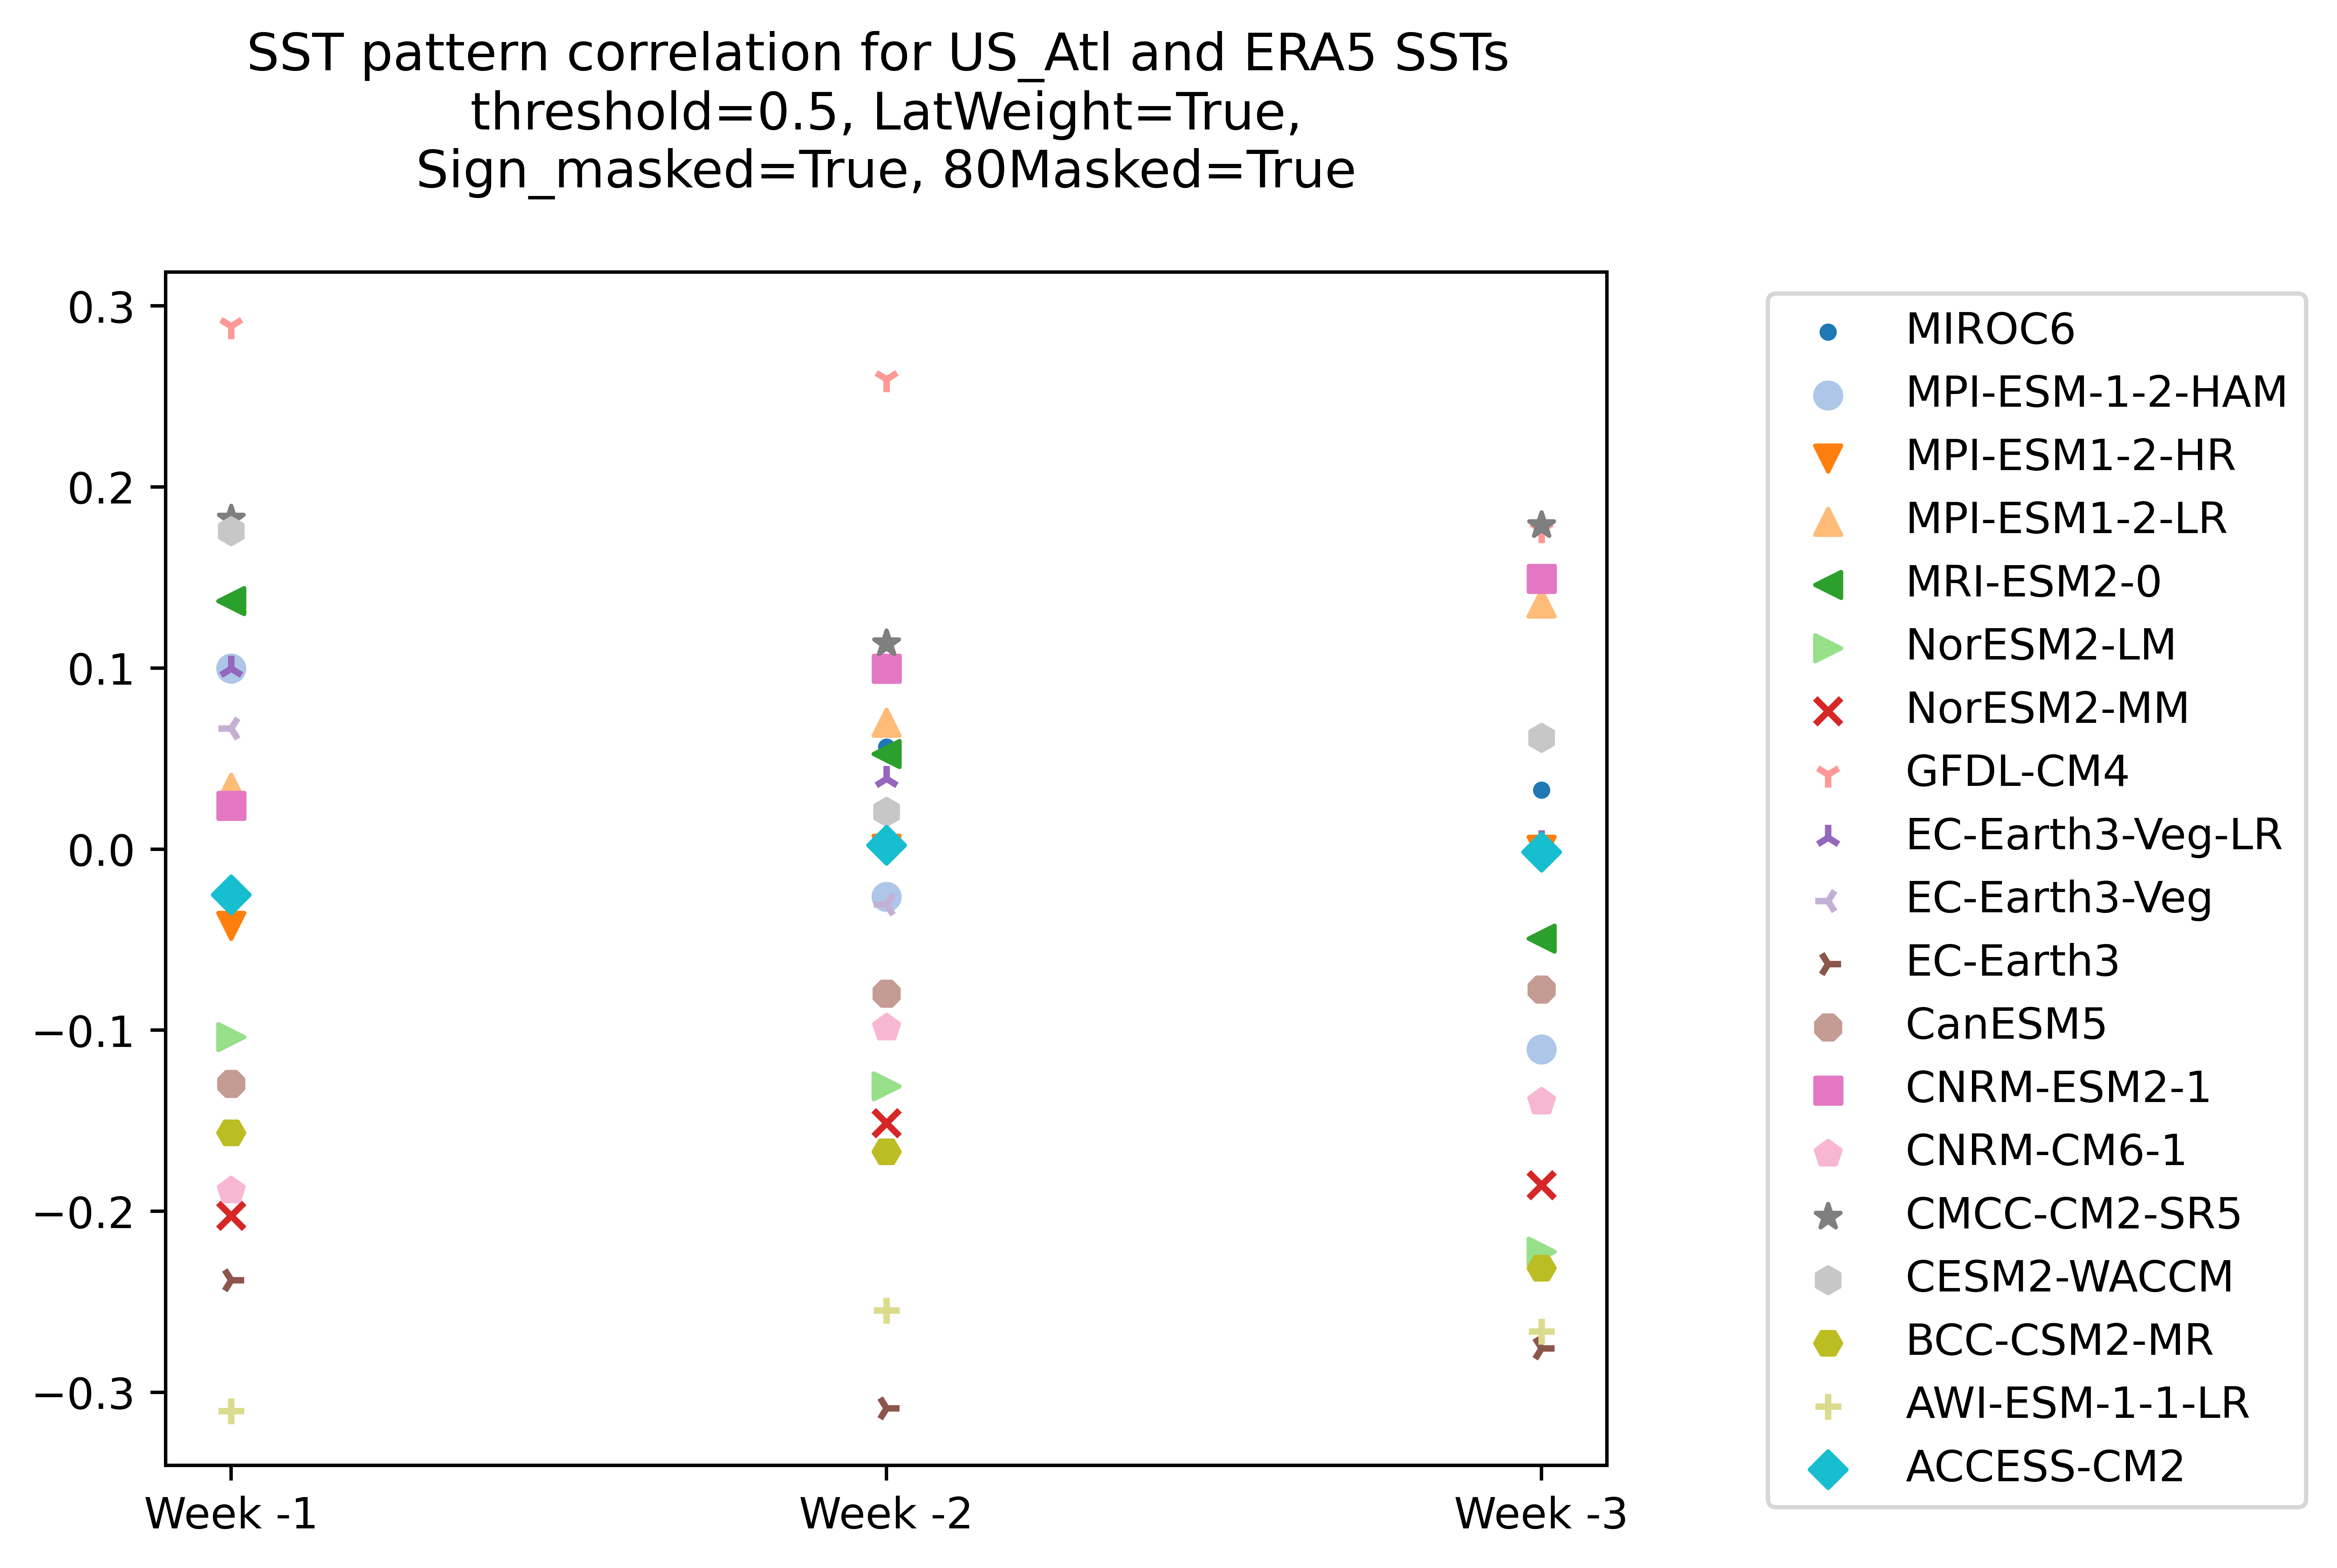

In [10]:
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["figure.dpi"]=900

for i, model in enumerate(data_covars["model_name"]):
    plt.scatter("Week -1", data_covars["week1"][i], c=color_dict[model], marker=marker_dict[model])
    plt.scatter("Week -2", data_covars["week2"][i], c=color_dict[model], marker=marker_dict[model])
    plt.scatter("Week -3", data_covars["week3"][i], c=color_dict[model], marker=marker_dict[model], label=model)
    
plt.legend(loc="upper right", bbox_to_anchor=(1.5,1))
plt.title(f"SST pattern correlation for {region} and ERA5 SSTs \n threshold={threshold_cov}, LatWeight={lat_weighting}, \n Sign_masked={Sign_masked}, 80Masked={mask_above_80} \n")


Text(0.5, 1.0, 'SST pattern correlation for EURASIA and ERA5 SSTs \n threshold=0.5, LatWeight=True, \n Sign_masked=True, 80Masked=True \n')

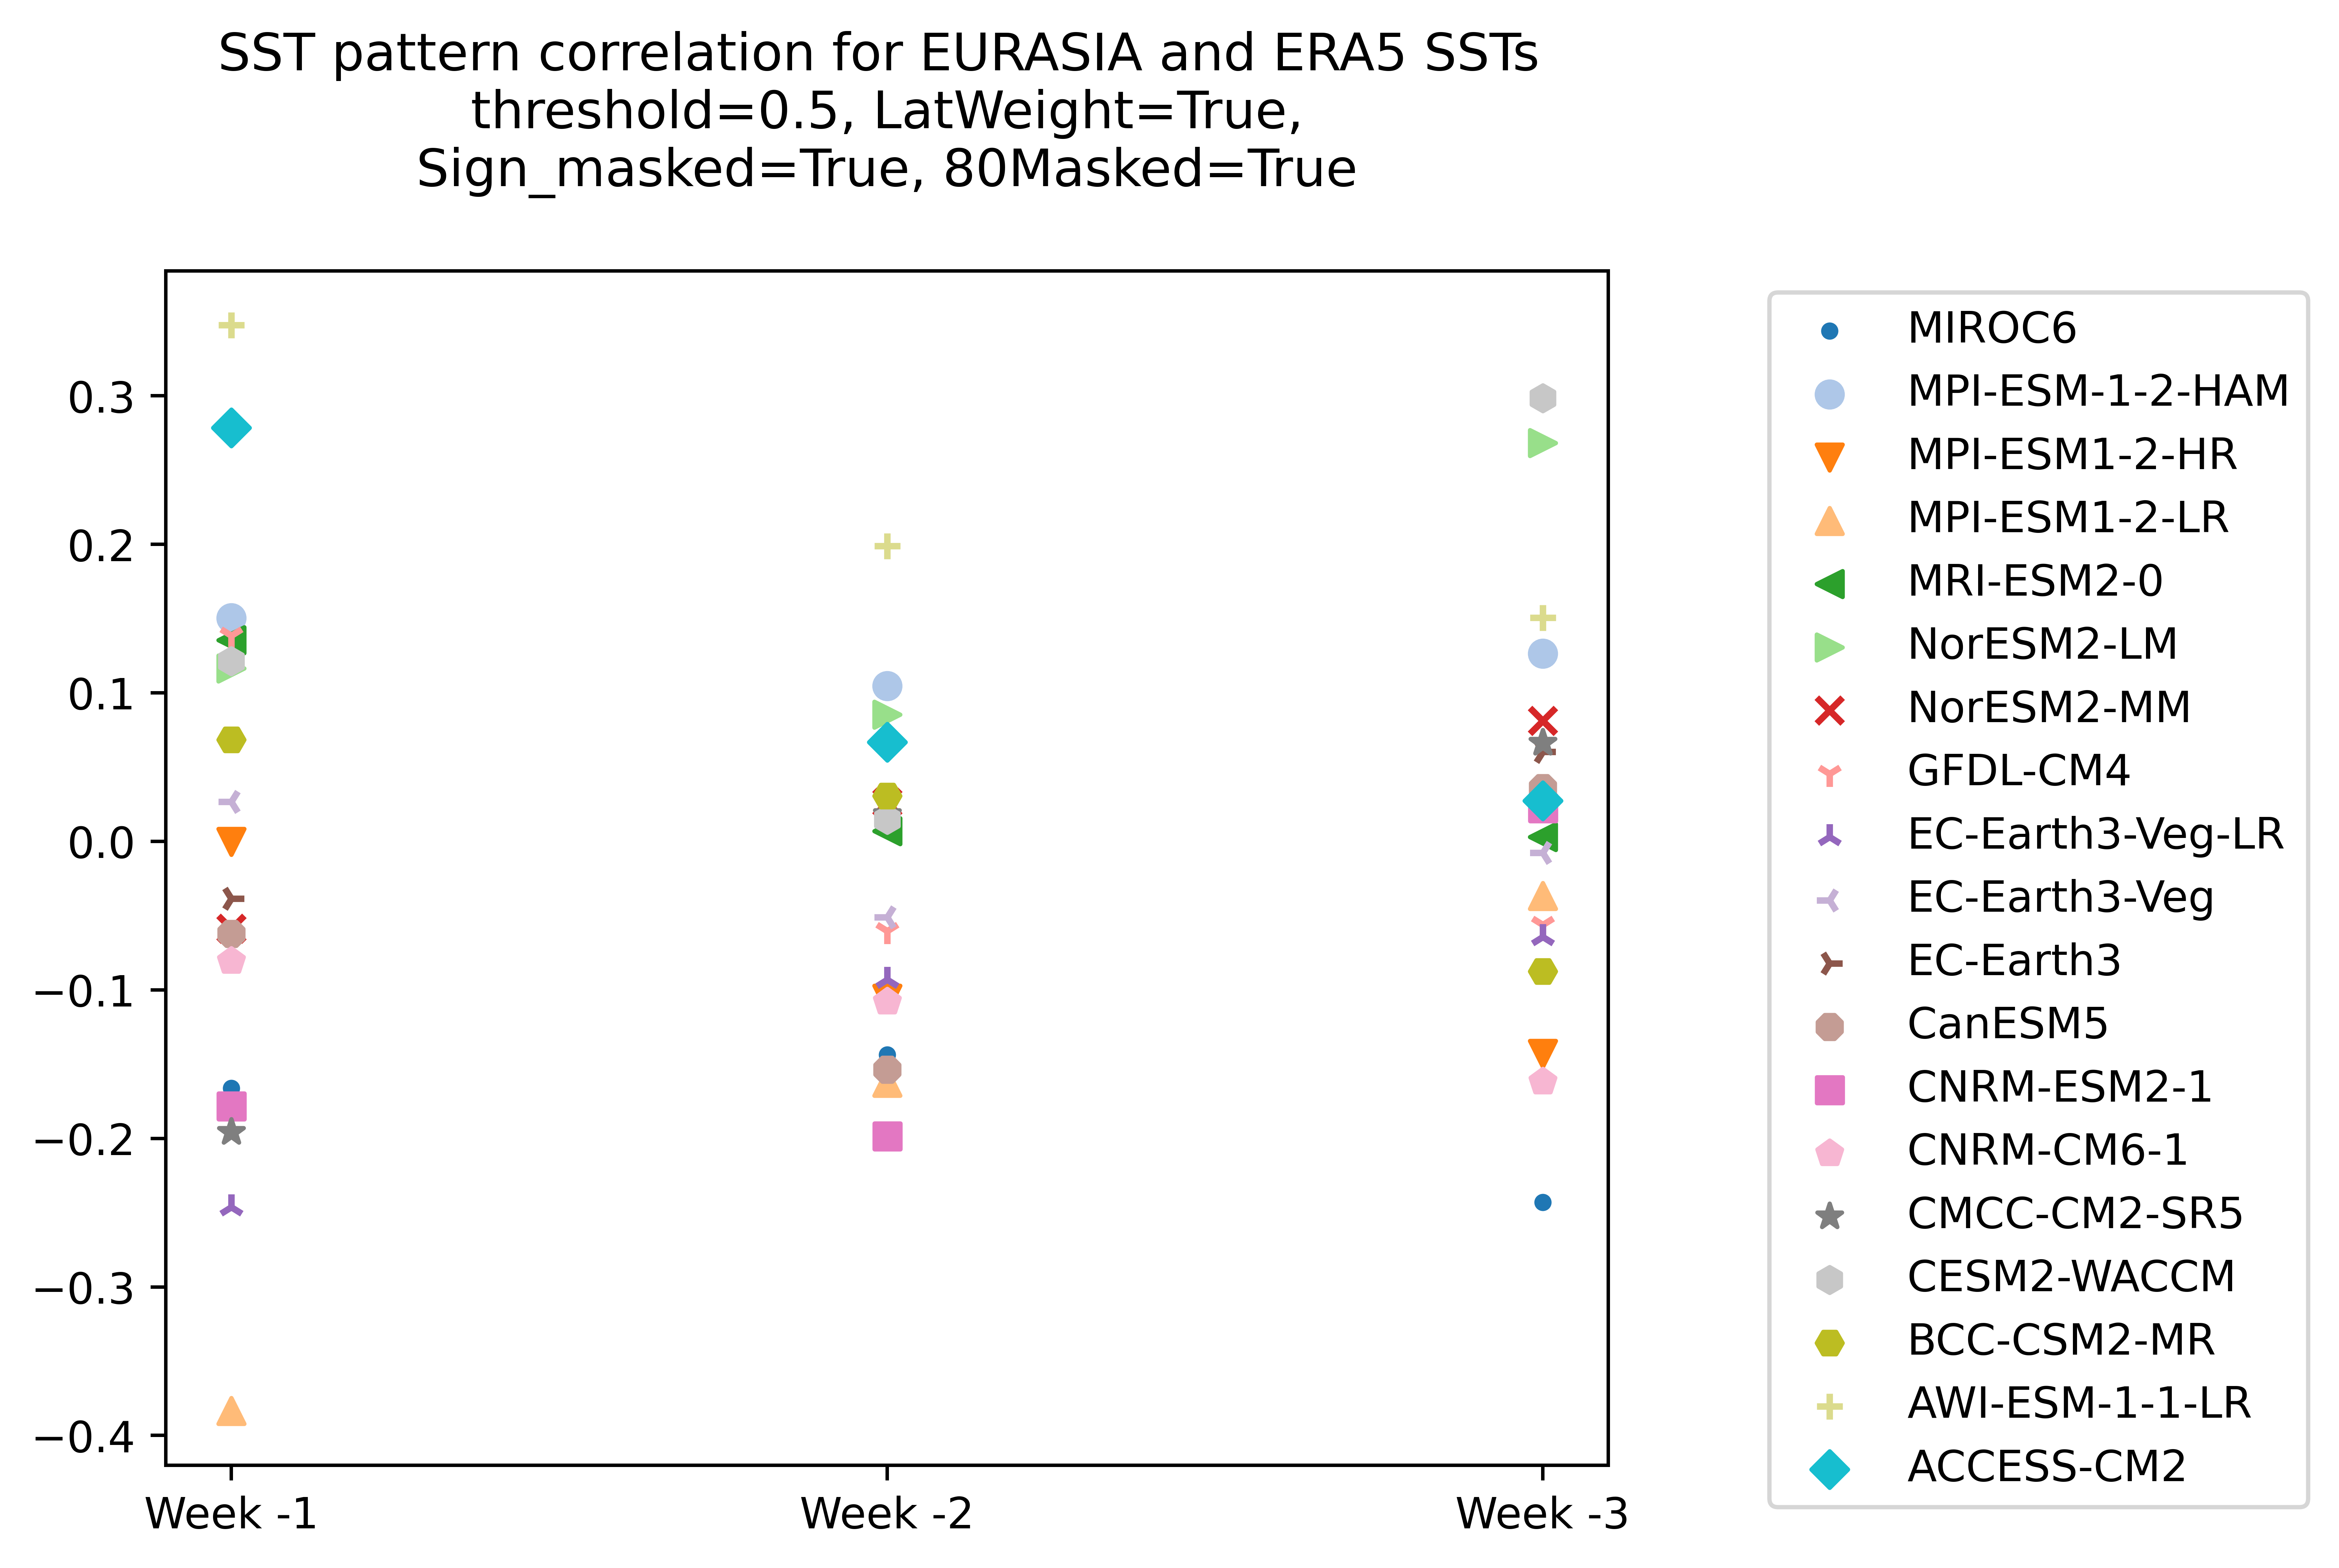

In [12]:
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["figure.dpi"]=900

for i, model in enumerate(data_covars["model_name"]):
    plt.scatter("Week -1", data_covars["week1"][i], c=color_dict[model], marker=marker_dict[model])
    plt.scatter("Week -2", data_covars["week2"][i], c=color_dict[model], marker=marker_dict[model])
    plt.scatter("Week -3", data_covars["week3"][i], c=color_dict[model], marker=marker_dict[model], label=model)
    
plt.legend(loc="upper right", bbox_to_anchor=(1.5,1))
plt.title(f"SST pattern correlation for {region} and ERA5 SSTs \n threshold={threshold_cov}, LatWeight={lat_weighting}, \n Sign_masked={Sign_masked}, 80Masked={mask_above_80} \n")
